# NR data eccentricities from Tamal's paper

In [1]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform

from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs

from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
from IPython.display import HTML,display
import pandas as pd
mode2polfac=4*(5/(64*np.pi))**(1/2)

In [5]:
origin = "LAL"

q = 2
M = 30
D = 1
e0 = 0.12
l0 = -0.181
flow = 13 #14.56 
xlow = ((M*MTSUN_SI*math.pi*flow)**(2/3))
D_SI=D*(10**(6))*PC_SI
M_SI=M*MSUN_SI
M1=q*M/(1+q)
M2=M/(1+q)
mode2polfac=4*(5/(64*np.pi))**(1/2)
print(xlow,xlow**1.5)

fMIN=(0.045**(3/2)/(30*MTSUN_SI*math.pi))                   # Total mass 46.39 for f0 = 13.3 at x0 = 0.045
print(fMIN) #find the freq corresponding to x0=0.045 for M=30

0.03314688141252297 0.006034815704256361
20.563550931756406


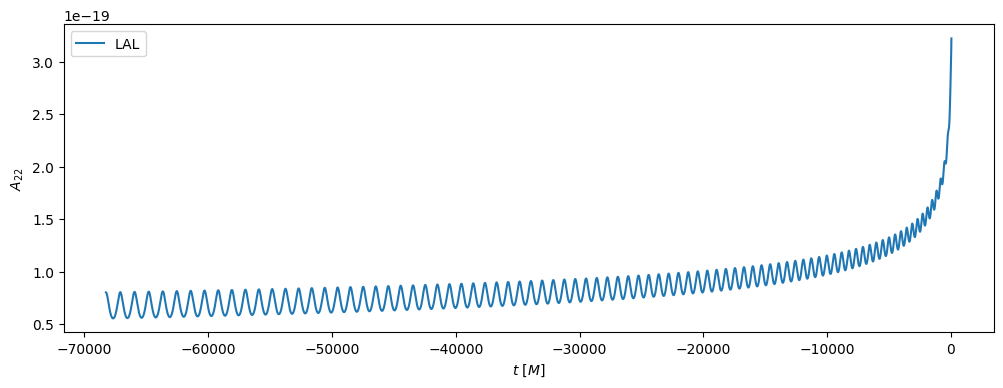

In [6]:
kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": xlow**(3/2),
    "physicalUnits":True,
    "M": M,
    "D": D,
    "include_zero_ecc":True,
}

dataDict = load_waveform(origin, **kwargs)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict["t"]/(M*MTSUN_SI), np.abs(dataDict["hlm"][(2, 2)]), label = origin)
#ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

21 0.10581936852279783 5.150143059122662


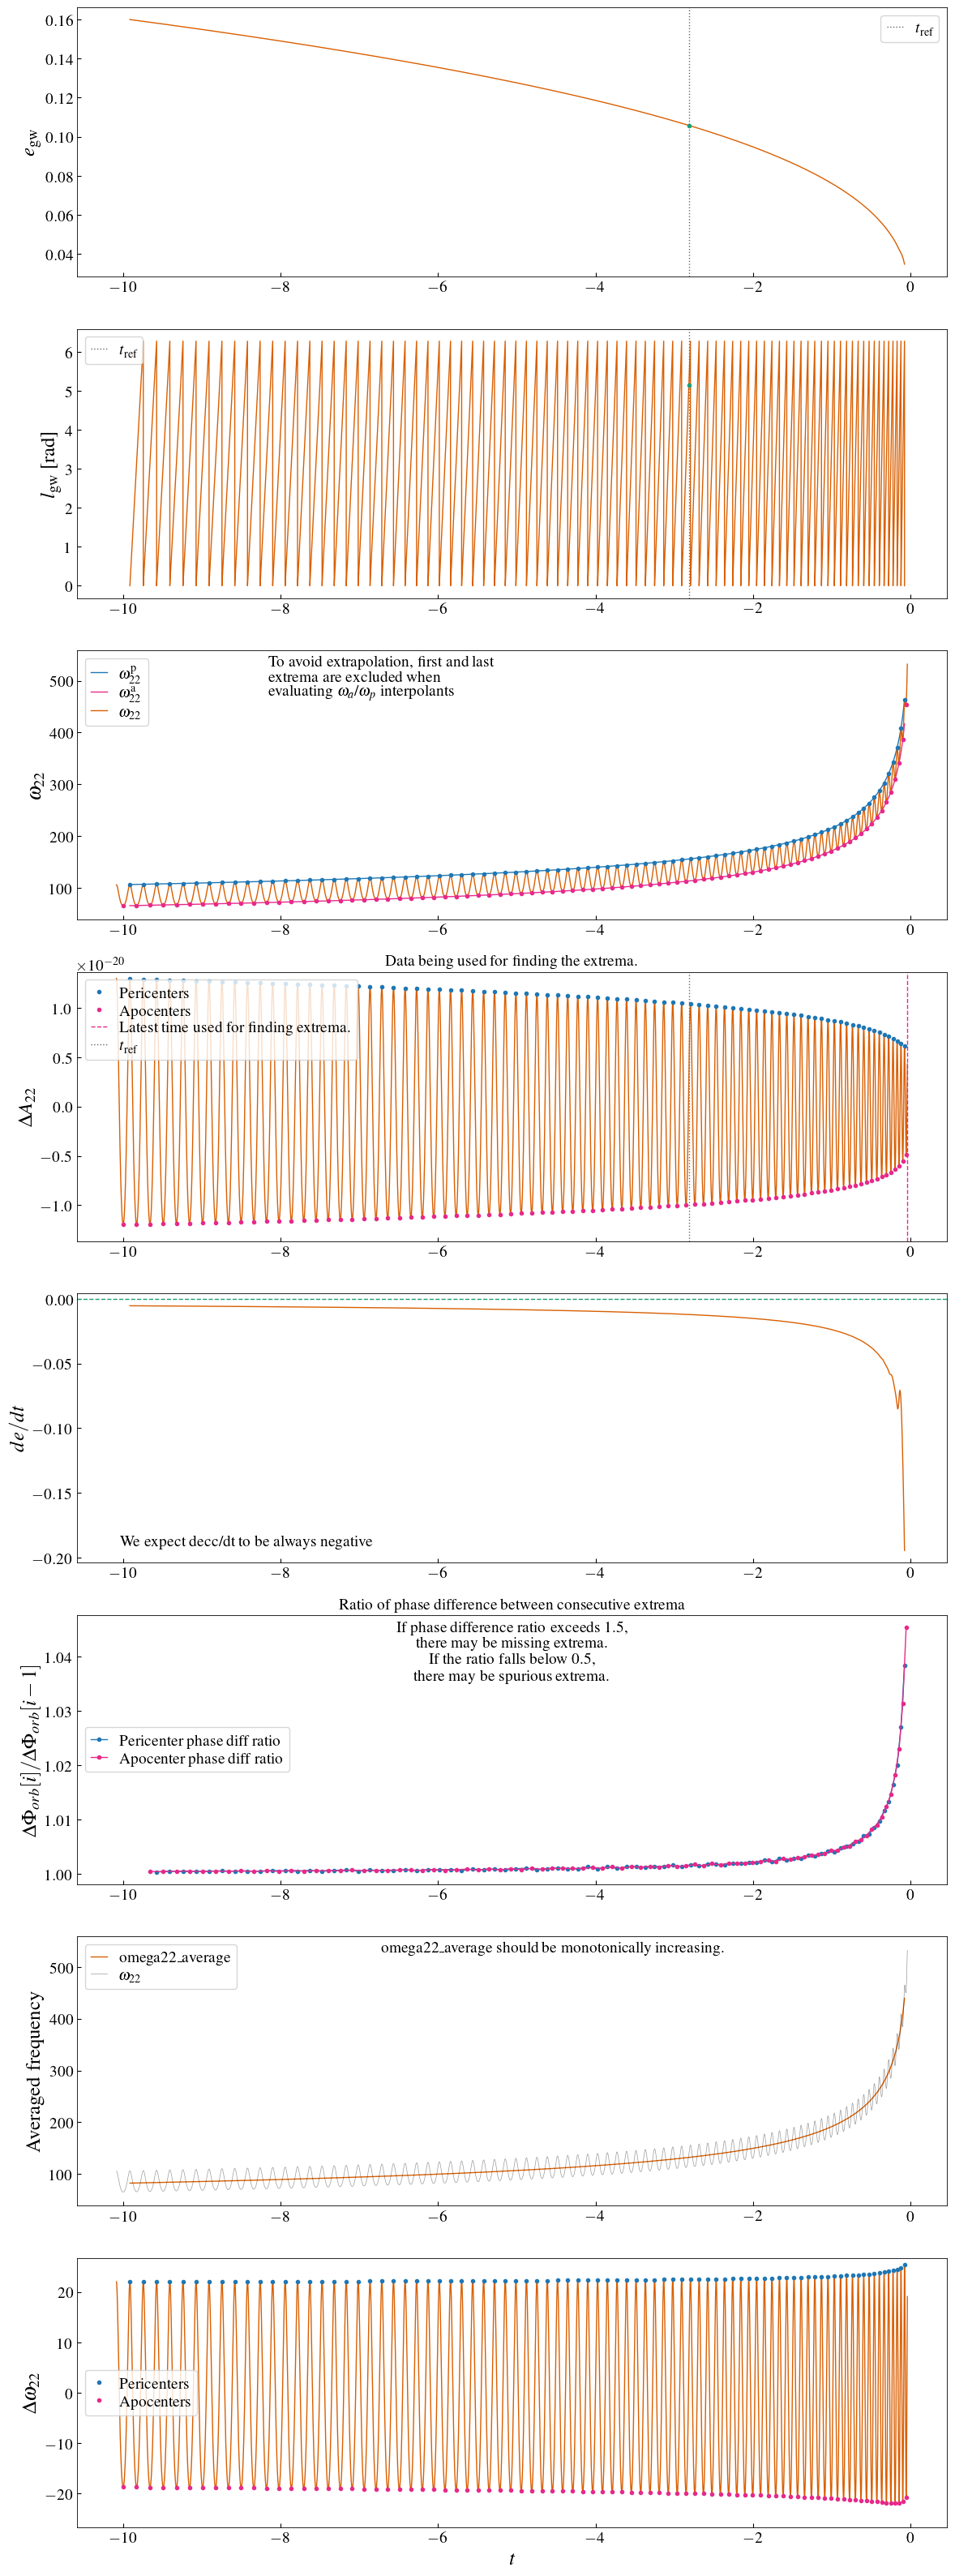

In [7]:
method = 'ResidualAmplitude'
return_dict = measure_eccentricity(fref_in=21, method = method, dataDict = dataDict)
eccentricity = return_dict["eccentricity"]
Mean_ano = return_dict["mean_anomaly"]
fref = return_dict["fref_out"]
gwecc_object= return_dict["gwecc_object"]
print(fref,(eccentricity),Mean_ano)
fig, ax = gwecc_object.make_diagnostic_plots()

In [8]:
hp = np.real(dataDict["hlm"][(2,2)])
hc = np.imag(dataDict["hlm"][(2,2)])
phaseEcc = np.unwrap(np.angle(hp-1j*hc)*2)/2
#plt.plot(dataDict["t"]/(M*MTSUN_SI),phaseEcc)

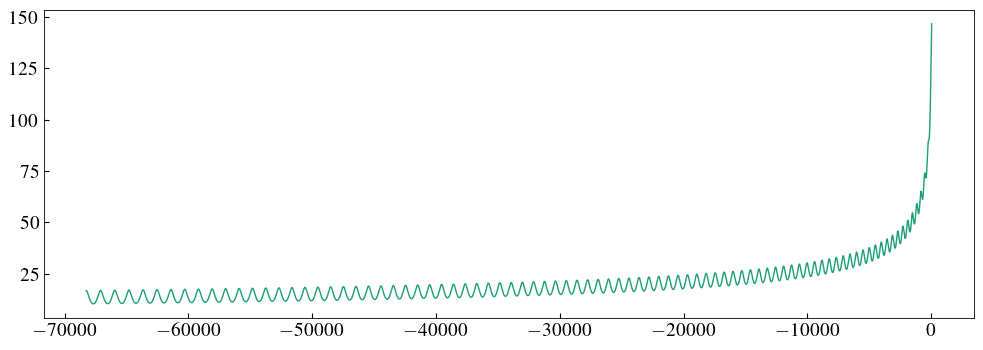

In [9]:
plt.figure(figsize=(12,4))
delta_t =  np.abs(np.mean((np.diff(dataDict["t"]))))
omega22 = (1/delta_t)*(np.gradient(phaseEcc))
plt.plot(dataDict["t"]/(M*MTSUN_SI),omega22/(2*PI))

The next block might throw error. Ignore it and proceed

In [10]:
plt.figure(figsize=(12,4))
method = 'ResidualAmplitude'
return_dict = measure_eccentricity(fref_in=omega22/(2*PI), method = method, dataDict = dataDict)

eccentricity1 = return_dict["eccentricity"]
fref = return_dict["fref_out"]#-(29.929229410284222-20)#-(21-13.3) #13.3 gives good result in Pn-NR freq plot
gwecc_object= return_dict["gwecc_object"]
Mean_ano = return_dict["mean_anomaly"]
#print(len(tref),len(eccentricity))

Ecc_intrp = interp1d(fref,eccentricity1,kind='cubic',fill_value='extrapolate')
Mean_ano_intrp = interp1d(fref,Mean_ano,kind='cubic',fill_value='extrapolate')

Xlow = 0.045
Flow = (Xlow**(3/2)/(30*MTSUN_SI*math.pi))

print(Ecc_intrp(20),Ecc_intrp(13.3))  #29.929229410284222
plt.plot(fref,eccentricity1)
#plt.xlabel('fref');plt.ylabel('e')

ValueError: Expect x to not have duplicates

<Figure size 1200x400 with 0 Axes>

In [11]:
a=gwecc_object.compute_res_amp_and_omega22()
print(a)

None


In [12]:
method = 'ResidualAmplitude'
return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
eccentricity = return_dict["eccentricity"]
tref = return_dict["tref_out"]
gwecc_object= return_dict["gwecc_object"]
avg_freq = (gwecc_object.get_omega22_average()[1])/(2*PI)
#print(len(avg_freq),len(eccentricity))

In [13]:
#print((np.intersect1d(dataDict["t"],tref)))
ind_min = np.where(dataDict["t"]==min(tref))[0][0]
ind_max = np.where(dataDict["t"]==max(tref))[0][0]
print(ind_min,ind_max,len(omega22))

11589 677419 683116


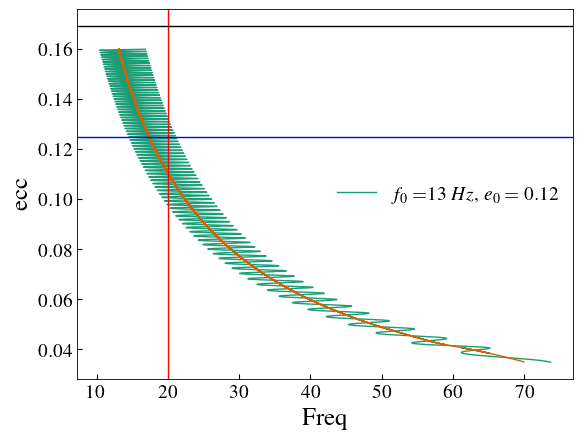

In [14]:
#plt.figure(figsize=(12,4))
Freq = (omega22/(2*PI))
plt.plot(Freq[ind_min:ind_max+1],eccentricity,label='$f_0=$'+str(flow)+' $Hz$, $e_0 = 0.12$')#-(29.929229410284222-20)#-(21-13.3)
plt.plot(fref,eccentricity1)
plt.axvline(x=20,color='r')
plt.axhline(y=0.16909765517977837,color='k')
plt.axhline(y=0.12497327937633551,color='b')
plt.xlabel('Freq');plt.ylabel('ecc')
#plt.ylim(0.08,0.19)
plt.legend()
#plt.savefig('test_ecc2.pdf',dpi=300)

In [15]:
dict_csv = {'Frequency': Freq[ind_min:ind_max+1], 'Eccentricity':eccentricity}
df = pd.DataFrame(dict_csv)
print(df)
#df.to_csv('Ecc vs Freq.csv')

        Frequency  Eccentricity
0       16.881020      0.159921
1       16.881026      0.159921
2       16.881031      0.159921
3       16.881033      0.159921
4       16.881033      0.159921
...           ...           ...
665826  73.672890      0.034889
665827  73.676561      0.034886
665828  73.680214      0.034883
665829  73.683848      0.034881
665830  73.687462      0.034878

[665831 rows x 2 columns]


In [76]:
print(len(omega22),len(dataDict["t"]))

209826 209826


In [13]:
a=[2,3,4,5,6,7]
print((a[2:4]))

[4, 5]


In [14]:
#help(gwecc_object)

# Using Hybrids to generate new eccentricity

26347


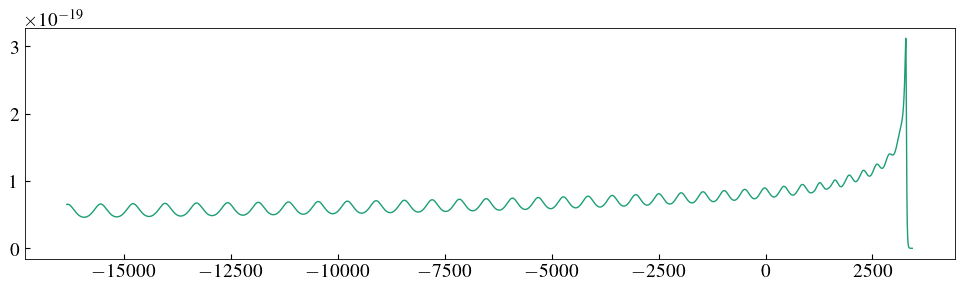

In [15]:
hf = h5py.File(f"1364_EccTD_Ebersold_HM.h5","r")
data = hf['l2_m2']
t_ecc_hyb = np.real(data[:,0]) 
hp_ecc_hyb = np.real(data[:,1])
hc_ecc_hyb = np.real(data[:,2])
delta_t_hyb = delta_t_hyb =  np.abs(np.mean((np.diff(t_ecc_hyb))))


D_SI = (10**(6))*PC_SI
t_hyb = np.linspace(t_ecc_hyb.min(),t_ecc_hyb.max(),int((t_ecc_hyb.max()-t_ecc_hyb.min())/delta_t_hyb))
hp_int = interp1d(t_ecc_hyb,hp_ecc_hyb,kind='cubic')
hc_int = interp1d(t_ecc_hyb,hc_ecc_hyb,kind='cubic')
hp_hyb = hp_int(t_hyb)*(G_SI*30*MSUN_SI/D_SI/C_SI/C_SI * mode2polfac)
hc_hyb = hc_int(t_hyb)*(G_SI*30*MSUN_SI/D_SI/C_SI/C_SI * mode2polfac)


#(G_SI*M_SI/D_SI/C_SI/C_SI * mode2polfac)
t_hyb = t_hyb*(30*MTSUN_SI)
#hp_hyb = TimeSeries(hp_hyb,delta_t_hyb,epoch=0)
#hc_hyb = TimeSeries(hc_hyb,delta_t_hyb,epoch=0)

h22_ecc_hyb = hp_hyb+1j*hc_hyb
dataDict_hyb = {"t": t_hyb,                                    #23050
           "hlm": {(2, 2): h22_ecc_hyb},
            'treat_mid_points_between_pericenters_as_apocenters': True
           }
hf.close()

print(len(t_hyb))
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(dataDict_hyb["t"]/(30*MTSUN_SI),np.abs(dataDict_hyb["hlm"][(2, 2)]))
#ax.set_xlim(-1200,)
#ax.set_ylim(0.01,1)

(0.0, 200.0)

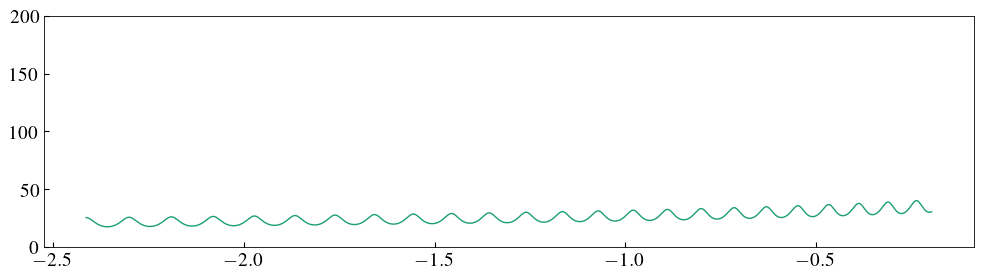

In [16]:
hp_hyb = np.real(dataDict_hyb["hlm"][(2,2)])
hc_hyb = np.imag(dataDict_hyb["hlm"][(2,2)])
#print(hp_hyb)
del_t = np.abs(np.mean((np.diff(t_hyb))))  
phaseEcc_hyb = np.unwrap(np.angle(hp_hyb-1j*hc_hyb)*2)/2
np.delete(phaseEcc_hyb,-1)
omega22_hyb = (1/del_t)*(np.gradient(phaseEcc_hyb))
plt.figure(figsize=(12,3))
plt.plot((dataDict_hyb["t"])[:20000],(omega22_hyb/(2*PI))[:20000])
#plt.xlim(-2.5,)
plt.ylim(0,200)

26347


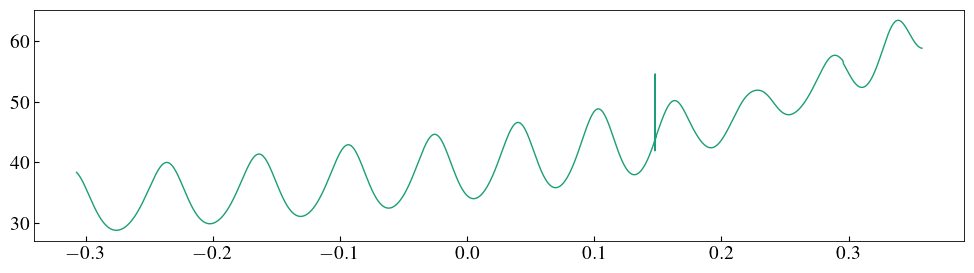

In [17]:
OMG_intp = interp1d((dataDict_hyb["t"]),(omega22_hyb/(2*PI)),kind='cubic',fill_value='extrapolate')
First_part = (omega22_hyb/(2*PI))[:20000]
last_part = (omega22_hyb/(2*PI))[24000:]
middle_part = OMG_intp((dataDict_hyb["t"])[20000:24000])
OMG22 = np.append(First_part,middle_part)
OMG22 = np.append(OMG22,last_part)
plt.figure(figsize=(12,3))
plt.plot((dataDict_hyb["t"])[19000:25000],OMG22[19000:25000])

print(len(OMG22))

In [18]:
print(len(First_part),len(middle_part),len(last_part),23050+950+2347)
#print((dataDict_hyb["t"])[23050]) #23050

20000 4000 2347 26347


In [19]:
# plt.figure(figsize=(12,4))
method = 'Amplitude'
return_dict_hyb = measure_eccentricity(fref_in=omega22_hyb/(2*PI), method = method, dataDict = dataDict_hyb)

eccentricity = return_dict_hyb["eccentricity"]
#print(eccentricity)
fref = return_dict_hyb["fref_out"]#-(21-13.3)#-(21.223085922955583-13.3)  #(21-13.3) #13.3 gives good result in Pn-NR freq plot
gwecc_object= return_dict_hyb["gwecc_object"]
Mean_ano = return_dict_hyb["mean_anomaly"]
print(len(tref),len(eccentricity))

Ecc_intrp = interp1d(fref,eccentricity,kind='cubic',fill_value='extrapolate')
Mean_ano_intrp = interp1d(fref,Mean_ano,kind='cubic',fill_value='extrapolate')

Xlow = 0.045
Flow = (Xlow**(3/2)/(30*MTSUN_SI*math.pi))

print(Ecc_intrp(20),Mean_ano_intrp(20))
fig,ax = plt.subplots(figsize=(12,3))
plt.plot(fref,eccentricity)
plt.xlabel('fref');plt.ylabel('e')
#plt.xlim(30,31)

/home/pratul/anaconda3/envs/pycbc/lib/python3.7/site-packages/gw_eccentricity/eccDefinition.py:226: UserWarning: kw treat_mid_points_between_pericenters_as_apocenters is not a recognized key word in dataDict.
  debug_level=self.debug_level)


Exception: Interpolated omega22_average are non-monotonic.
First non-monotonicity occurs at peak number 0, where omega22 drops from 130.4801775237467 to 130.4782186711951, a decrease by 0.00195885255160988.
Total number of places of non-monotonicity is 138.
Last one occurs at peak number 137.
For more verbose output use `debug_level=1` and for diagnostic plot use `debug_plots=True` in extra_kwargs
Possible fixes: 
   - Increase sampling rate of data
   - Add to extra_kwargs the option 'treat_mid_points_between_pericenters_as_apocenters': True

# Fixing $e_{ref}$ and $f_{ref}$ from Hinder's paper 

In [15]:
#SXS 1364 - Hinder
M0 = 30
e_ref =  0.044
x_ref = 0.075
l_ref = 2.132
f_ref = (x_ref**(3/2)/(M0*MTSUN_SI*math.pi))
print(f_ref)

44.245716831989206


## If we evolve EccentricTD with $f_0=14.56$ Hz and $e_0=0.12$, it returns $e = 0.125$ at $f = 20 Hz$ for which we get good PN-NR results. But the question is how are we choosing this 14.56 Hz ??

In [65]:
#e=[0.069]
flow = [14.56, 14.560018502585379]#np.arange(14.5,14.8,0.02)
M0 = 30
l0 = -0.181
e = 0.12
#print(e)
for f0 in flow:
    xlow = ((M*MTSUN_SI*math.pi*f0)**(2/3))
    print(xlow)
    kwargs = {
        "approximant": "EccentricTD",
        "q":2,
        "ecc":e,
        "chi1": [0.0,0.0,0.0],
        "chi2": [0.0,0.0,0.0],
        "mean_ano": l0,
        "Momega0": xlow**(3/2),
        "physicalUnits":True,
        "M": M0,
        "D":1,
        "include_zero_ecc":True
        }
    method = "ResidualAmplitude"
    origin = "LAL"
    dataDict1 = load_waveform(origin, **kwargs)
    return_dict1 = measure_eccentricity(fref_in = 20, method = method, dataDict=dataDict1)
    Ecc = return_dict1["eccentricity"]
    #print('e0 = ',i,'e_ref = ',Ecc, "x_ref = ",x_ref)
    print(f0,Ecc,abs(Ecc-0.125),'\n')

0.03574824203342955
14.56 0.12497327937633551 2.6720623664489018e-05 

0.03574827231890392
14.560018502585379 0.12497084691638916 2.9153083610844455e-05 



In [23]:
#NR = ['1355_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1356_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1357_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1358_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1359_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1360_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1361_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1362_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1363_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1365_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1366_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1367_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1368_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1369_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1370_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1371_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1372_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1373_rhOverM_Asymptotic_GeometricUnits_CoM.h5','1374_rhOverM_Asymptotic_GeometricUnits_CoM.h5']
NR = ['1364_rhOverM_Asymptotic_GeometricUnits_CoM.h5']
#Ecc_ini = [0.127,0.163,0.222,0.226,0.227,0.302,0.305,0.372,0.376,0.108,0.145,0.218,0.220,0.222,0.367,0.367,0.133,0.212,0.214,0.359]

In [24]:
#len(NR),len(Ecc_ini)

In [25]:
origin = "SXSCatalog"
get_load_waveform_defaults(origin)

{'filepath': None,
 'metadata_path': None,
 'deltaTOverM': 0.1,
 'include_zero_ecc': False,
 'include_params_dict': False,
 'zero_ecc_approximant': 'IMRPhenomT',
 'num_orbits_to_remove_as_junk': 2,
 'mode_array': [(2, 2)],
 'extrap_order': 2}

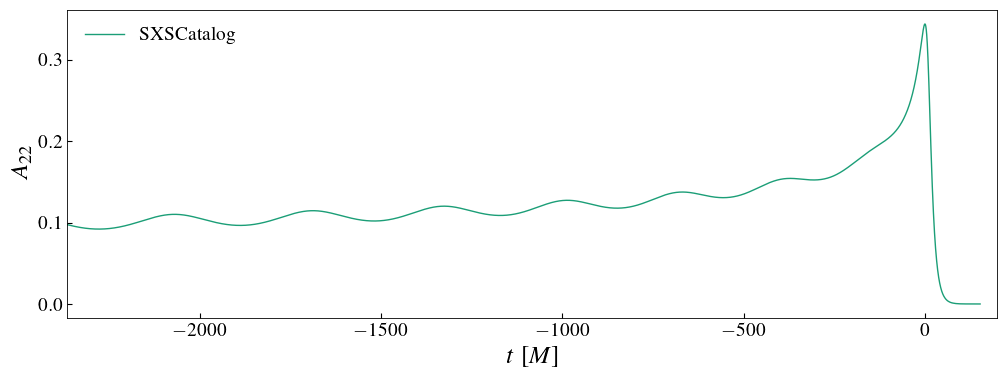

In [26]:
kwargs = {"filepath": "/home/pratul/Downloads/Project/NR_data/"+NR[0]}
dataDict = load_waveform(origin, **kwargs)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label = origin)
ax.set_xlim(dataDict["t"][0], 200)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

In [27]:
hp_NR = np.real(dataDict["hlm"][(2,2)])
hc_NR = np.imag(dataDict["hlm"][(2,2)])
phaseEcc_NR = np.unwrap(np.angle(hp_NR-1j*hc_NR)*2)/2
#plt.plot(dataDict["t"],hp_NR)

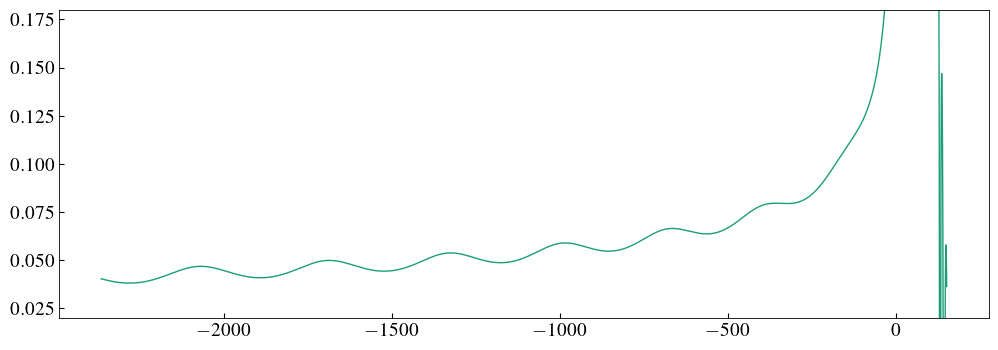

In [28]:
plt.figure(figsize=(12,4))
plt.ylim(0.02,0.18)
delta_t =  np.abs(np.mean((np.diff(dataDict["t"]))))
omega22 = (1/delta_t)*(np.gradient(phaseEcc_NR))
plt.plot(dataDict["t"],omega22)

In [29]:
#plt.figure(figsize=(12,4))
method = 'Amplitude'
return_dict = measure_eccentricity(fref_in=0.001, method = method, dataDict = dataDict)
e = return_dict["eccentricity"]
print(e)

Exception: fref_in is earlier than minimum available frequency 0.006829581142120837

In [24]:
method = 'Amplitude'
return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
eccentricity = return_dict["eccentricity"]
tref = return_dict["tref_out"]
gwecc_object= return_dict["gwecc_object"]
avg_freq_NR = (gwecc_object.get_omega22_average()[1])/(2*PI)

In [25]:
ind_min = np.where(dataDict["t"]==min(tref))[0][0]
ind_max = np.where(dataDict["t"]==max(tref))[0][0]
print(ind_min,ind_max,len(omega22))

2954 19939 25178


Text(0, 0.5, 'ecc')

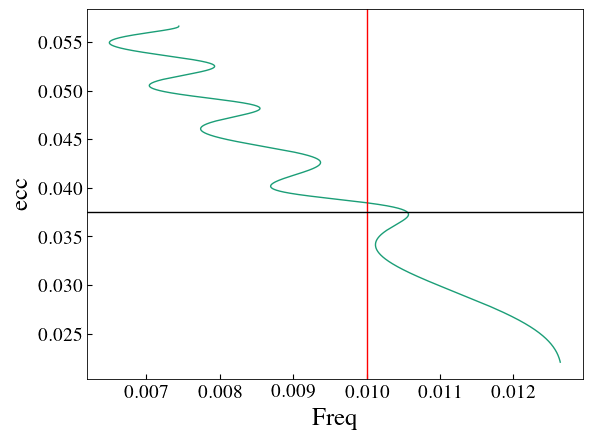

In [26]:
#plt.figure(figsize=(12,4))
Freq = (omega22/(2*PI))
plt.plot(Freq[ind_min:ind_max+1],eccentricity)
#plt.plot(avg_freq,eccentricity)
plt.axvline(x=0.01,color='r')
plt.axhline(y=0.037537434857726204,color='k')
plt.xlabel('Freq');plt.ylabel('ecc')
#plt.ylim(0.16,0.18)

# Measure $e_0$ using "$Amplitude$" method

In [27]:
method = 'Amplitude'
return_dict = measure_eccentricity(fref_in=0.011, method = method, dataDict = dataDict)
eccentricity = return_dict["eccentricity"]
gwecc_object = return_dict["gwecc_object"]
print(eccentricity)

0.03192963202130428


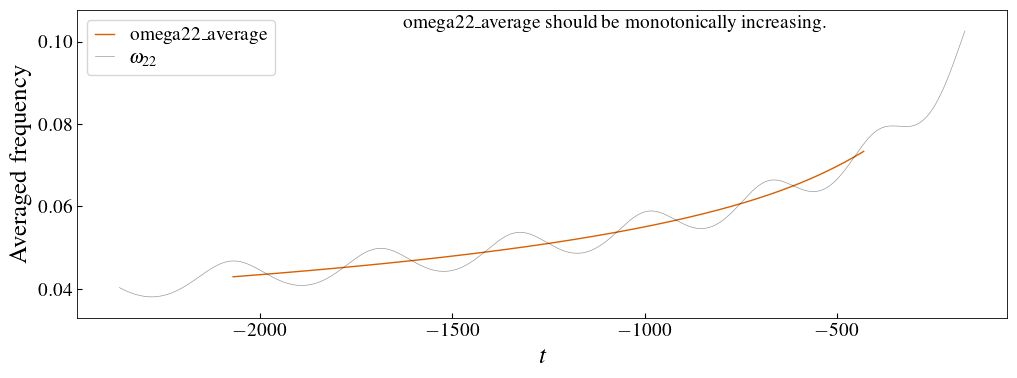

In [28]:
fig, ax = gwecc_object.plot_omega22_average()

In [18]:
xlow1 = ((30*MTSUN_SI*math.pi*13.3)**(2/3))
print(xlow1)

0.03365489193007444


In [19]:
#ecc_new = []
#def NR_Ecc(NR_data,method):
    #kwargs = {"filepath": "/home/pratul/Downloads/Project/NR_data/"+NR[NR_data]}
    #dataDict = load_waveform(origin, **kwargs)
    #return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
    #eccentricity = return_dict["eccentricity"]
    #return round(eccentricity[0],3)

In [20]:
#method='Amplitude'
#for i in range(0,len(NR)):
    #ecc_new.append(NR_Ecc(i,method))

In [21]:
#k=range(0,len(NR))
#plt.plot(k,Ecc_ini,'ro',label='old')
#plt.plot(k,ecc_new,'bo',label='new')
#plt.plot(k,Ecc_ini,'r-',k,ecc_new,'b-')
#plt.xlabel('NR index',size=15)
#plt.ylabel('$e_0$',size=15)
#plt.legend()

In [22]:
#a=[]
#for i in range(0,len(NR)):
    #a.append(NR[i][0:4])   
#a_list=[a,Ecc_ini,ecc_new]
#df=pd.DataFrame(a_list,index = ["NR data", "Old $e_0$", "New $e_0$"])
#display(HTML(df.to_html()))

# Interpolation

In [23]:
#ecc_new = []
#def NR_Ecc(NR_data,method):
    #kwargs = {"filepath": "/home/pratul/Downloads/Project/NR_data/"+NR[NR_data]}
    #dataDict = load_waveform(origin, **kwargs)
    #return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
    #eccentricity = return_dict["eccentricity"]
    #gwecc_object = return_dict["gwecc_object"]
    #Time = return_dict["tref_out"]
    #print(len(Time),len(dataDict["t"]),len(eccentricity))
    #intrp = interp1d(Time,eccentricity,kind='cubic',fill_value='extrapolate')
    #return around(intrp(dataDict["t"][0]),3)

In [24]:
#method='Amplitude'
#for i in range(0,len(NR)):
    #ecc_new.append(NR_Ecc(i,method))

In [25]:
#k=range(0,len(NR))
#plt.plot(k,Ecc_ini,'ro',label='old')
#plt.plot(k,ecc_new,'bo',label='new')
#plt.plot(k,Ecc_ini,'r-',k,ecc_new,'b-')
#plt.xlabel('NR index',size=15)
#plt.ylabel('$e_0$',size=15)
#plt.legend()

In [26]:
#a=[]
#for i in range(0,len(NR)):
    #a.append(NR[i][0:4])   
#a_list=[a,Ecc_ini,ecc_new]
#df=pd.DataFrame(a_list,index = ["NR data", "Old $e_0$", "New $e_0$"])
#display(HTML(df.to_html()))